# Imports 
Import the requisite python packages

In [194]:
from sklearn.decomposition import PCA
import pandas as pd
from pymatgen.core import Lattice, Structure, Molecule
import os
import numpy as np 
import ast
import matplotlib.pyplot as plt
from pymatgen.core.structure import Structure
import pandas as pd
import pickle
from pymatgen.core import Element
from ase.build import molecule
from ase import Atoms
from ase.io import read,write
import time
from pymatgen.transformations.standard_transformations import RotationTransformation
from pymatgen.transformations.site_transformations import TranslateSitesTransformation
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, UpSampling1D, Conv1D
from tensorflow.keras.activations import linear
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
import fnmatch
import copy
import random
from tensorflow.keras import activations
from tensorflow.keras.activations import linear
import pickle
from pymatgen.core import Structure
from pymatgen.io.vasp.outputs import Poscar
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf

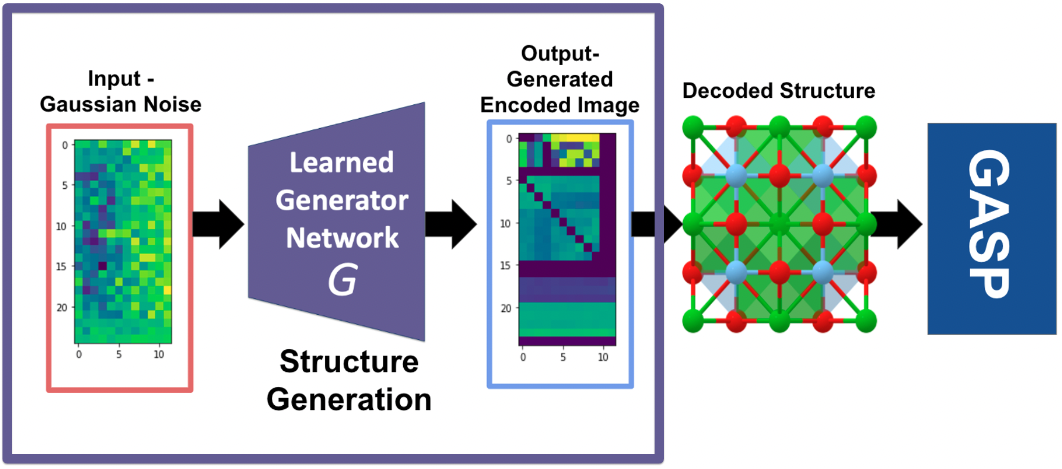

# <a name="outline"></a> Outline 


* Take me to [PCA on Element Data](#section_a)

* Take me to [Data Extraction](#section_b)

* Take me to [Featurization](#section_c)

* Take me to [The Wasserstein Generative Adversarial Network](#section_d)

In [2]:
df = pd.read_csv('/blue/hennig/sam.dong/elements.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df = df.iloc[:-6]

In [5]:
df_list = []
file_name = '/blue/hennig/sam.dong/element_data/matminer/matminer/utils/data_files/magpie_elementdata/NfValence.table'
with open(file_name, 'r') as file:
    for line in file:
        df_list.append(int(line))
name = 'nf_valence'
df[name] = df_list
element_features_df = df.loc[:,['AtomicNumber','AtomicMass','Period','Group','Electronegativity','Phase','Type','FirstIonization','Density','MeltingPoint','BoilingPoint','SpecificHeat','NumberofValence']] 

## <a name="section_a"></a>  PCA on Element Data
The descriptor that will be used is a modified version of the CrysTens representation. To introduce chemical intuition, elemental descriptors will be made from similarity calculations between PCA vectors on element data. 
* Go back to [Outline](#outline)

In [6]:
element_features_df

,AtomicNumber,AtomicMass,Period,Group,Electronegativity,Phase,Type,FirstIonization,Density,MeltingPoint,BoilingPoint,SpecificHeat,NumberofValence
0,1,1.007,1,1.0,2.20,gas,Nonmetal,13.5984,0.000090,14.175,20.28,14.304,1.0
1,2,4.002,1,18.0,NaN,gas,Noble Gas,24.5874,0.000179,NaN,4.22,5.193,NaN
2,3,6.941,2,1.0,0.98,solid,Alkali Metal,5.3917,0.534000,453.850,1615.00,3.582,1.0
3,4,9.012,2,2.0,1.57,solid,Alkaline Earth Metal,9.3227,1.850000,1560.150,2742.00,1.825,2.0
4,5,10.811,2,13.0,2.04,solid,Metalloid,8.2980,2.340000,2573.150,4200.00,1.026,3.0
5,6,12.011,2,14.0,2.55,solid,Nonmetal,11.2603,2.270000,3948.150,4300.00,0.709,4.0
6,7,14.007,2,15.0,3.04,gas,Nonmetal,14.5341,0.001250,63.290,77.36,1.040,5.0
7,8,15.999,2,16.0,3.44,gas,Nonmetal,13.6181,0.001430,50.500,90.20,0.918,6.0
8,9,18.998,2,17.0,3.98,gas,Halogen,17.4228,0.001700,53.630,85.03,0.824,7.0
9,10,20.180,2,18.0,NaN,gas,Noble Gas,21.5645,0.000900,24.703,27.07,1.030,8.0


* element_features_df is a pandas dataframe which contains elemental data of elements 1-112 which includes atomic number, mass, electronegativity, first ionization energy etc. 

* in the interest of PCA, this dataframe will be normalized through min-max normalization

In [62]:
with open('/blue/hennig/sam.dong/final_element_data.pkl','rb') as file:
    normalized_df = pickle.load(file)
    file.close()

In [63]:
normalized_df

,Period,Group,Electronegativity,Phase,FirstIonization,Density,MeltingPoint,BoilingPoint,SpecificHeat,NumberofValence
0,0.000000,0.083333,0.000000,0.0,0.000000,0.088889,0.000000,0.000681,0.278048,0.125
1,0.000000,1.500000,0.000000,0.333333,1.000000,0.088893,0.000000,0.001400,1.000000,0.000
2,0.166667,0.083333,0.320101,1.0,0.219287,0.100756,0.114953,0.275668,0.776032,0.125
3,0.166667,0.166667,0.512814,1.0,0.379166,0.130000,0.395160,0.467563,0.531767,0.250
4,0.166667,1.083333,0.666332,1.0,0.337490,0.140889,0.651736,0.715818,0.420687,0.375
5,0.166667,1.166667,0.832915,1.0,0.457970,0.139333,1.000000,0.732845,0.376616,0.500
6,0.166667,1.250000,0.992965,0.333333,0.591120,0.088917,0.016030,0.013853,0.422633,0.625
7,0.166667,1.333333,1.123618,0.333333,0.553865,0.088921,0.012791,0.016040,0.405672,0.750
8,0.166667,1.416667,1.300000,0.333333,0.708607,0.088927,0.013584,0.015159,0.392604,0.875
9,0.166667,1.500000,0.000000,0.333333,0.877055,0.088909,0.006257,0.005290,0.421243,1.000


###   Perform PCA on normalized element data

In [64]:

pca = PCA(n_components = 8)
pca.fit(normalized_df)    

PCA(n_components=8)

In [65]:
explained_variance_ratios = pca.explained_variance_ratio_
sum(explained_variance_ratios)

0.9872687510417435

In [66]:
# Transform the original DataFrame into the reduced feature space
df_pca = pca.transform(normalized_df)

# Convert the result to a new DataFrame if needed
df_pca = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(8)])


In [83]:

pca_elem_list = []
for i in df_pca.iloc():
    pca_elem_list.append(i.values)

In [84]:
transition_metals = ['Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Zr', 'Nb', 'Mo', 'Tc',
                      'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg',
                      'Rf', 'Db', 'Sg', 'Bh', 'Hs']
alkali_metals = ['Li', 'Na', 'K', 'Rb', 'Cs', 'Fr']
alkaline_earth_metals = ['Be', 'Mg', 'Ca', 'Sr', 'Ba', 'Ra']
metalloids = ['B', 'Si', 'Ge', 'As', 'Sb', 'Te']
post_transition_metals = ['Al', 'Ga', 'In', 'Sn', 'Tl', 'Pb', 'Bi', 'Po']
reactive_non_metals = ['H','C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Se', 'Br', 'I']
noble_gases = ['He', 'Ne', 'Ar', 'Kr', 'Xe', 'Rn']
unknown = ['Mt', 'Ds', 'Rg', 'Cn']
lanthanides = ['La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu']
actinides = ['Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr']


In [102]:


def elem_similarity_pca(reference_elem,pca_elem_list):
    """
    elem_similarity_pca:
    
    is a function that takes a reference element and calculates the cosine similarity between that 
    reference element's PCA vector with all other element PCA vectors
    
    Args:
        reference_elem: a str that contains the chemical symbol you want as your reference element i.e. "H" 
        for hydrogen. 
        
        pca_elem_list: a list of numpy arrays representing elemental descriptors for chemical elements
        
    Returns:
        sorted_dict: a dictionary that contains the chemical symbols as keys and relative cosine similarity 
        with the reference element as values. This dictionary is ranked by similarity 
        
        similarity_dict: a dictionary that contains the chemical symbols as keys and relative cosine similarity 
        with the reference elmenet as values. This dictionary is sorted by periodic number. 
    
    """
    
    
    
    element_dict = {'H': 0, 'He': 1, 'Li': 2, 'Be': 3, 'B': 4, 'C': 5, 'N': 6, 'O': 7, 'F': 8, 'Ne': 9,
        'Na': 10, 'Mg': 11, 'Al': 12, 'Si': 13, 'P': 14, 'S': 15, 'Cl': 16, 'Ar': 17, 'K': 18,
        'Ca': 19, 'Sc': 20, 'Ti': 21, 'V': 22, 'Cr': 23, 'Mn': 24, 'Fe': 25, 'Co': 26, 'Ni': 27,
        'Cu': 28, 'Zn': 29, 'Ga': 30, 'Ge': 31, 'As': 32, 'Se': 33, 'Br': 34, 'Kr': 35, 'Rb': 36,
        'Sr': 37, 'Y': 38, 'Zr': 39, 'Nb': 40, 'Mo': 41, 'Tc': 42, 'Ru': 43, 'Rh': 44, 'Pd': 45,
        'Ag': 46, 'Cd': 47, 'In': 48, 'Sn': 49, 'Sb': 50, 'Te': 51, 'I': 52, 'Xe': 53, 'Cs': 54,
        'Ba': 55, 'La': 56, 'Ce': 57, 'Pr': 58, 'Nd': 59, 'Pm': 60, 'Sm': 61, 'Eu': 62, 'Gd': 63,
        'Tb': 64, 'Dy': 65, 'Ho': 66, 'Er': 67, 'Tm': 68, 'Yb': 69, 'Lu': 70, 'Hf': 71, 'Ta': 72,
        'W': 73, 'Re': 74, 'Os': 75, 'Ir': 76, 'Pt': 77, 'Au': 78, 'Hg': 79, 'Tl': 80, 'Pb': 81,
        'Bi': 82 ,'Po': 83,'At': 84,'Rn': 85,'Fr': 86,'Ra': 87,'Ac': 88,'Th': 89,'Pa': 90,'U': 91,'Np': 92,
        'Pu': 93,'Am': 94,'Cm': 95,'Bk': 96,'Cf': 97,'Es': 98,'Fm': 99,'Md': 100,'No': 101,'Lr': 102,'Rf': 103,'Db': 104,
        'Sg': 105,'Bh': 106,'Hs': 107,'Mt': 108,'Ds': 109,'Rg': 110,'Cn': 111}
    elem_list = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 
                        'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 
                        'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 
                        'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 
                        'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 
                        'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 
                        'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg', 
                        'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn']
    index = element_dict[reference_elem]
    vec1 = pca_elem_list[index].reshape(1,-1)
    similarity_dict = {}
    count = 0 
    for vector in pca_elem_list:
        vec2 = vector.reshape(1,-1)
        similarity = cosine_similarity(vec1,vec2)[0,0]
        similarity_dict[elem_list[count]] = similarity
        count = count+1
    sorted_dict = dict(sorted(similarity_dict.items(),key = lambda item:item[1]))
    return sorted_dict,similarity_dict

In [103]:
weighted_element_groups = {'H': 1/reactive_non_metals, 'He': 1/alkaline_earth_metals, 'Li': 1/alkaline_earth_metals, 'Be': 1/alkaline_earth_metals, 'B': 1/alkaline_earth_metals, 
                'C': 1/reactive_non_metals, 'N': 1/reactive_non_metals, 'O': 1/reactive_non_metals, 'F': 1/reactive_non_metals, 'Ne': 1/alkaline_earth_metals, 'Na': 1/alkaline_earth_metals, 
                'Mg': 1/alkaline_earth_metals, 'Al': 1/post_transition_metals, 'Si': 1/alkaline_earth_metals, 'P': 1/reactive_non_metals, 'S': 1/reactive_non_metals, 'Cl': 1/reactive_non_metals, 
                'Ar': 1/alkaline_earth_metals, 'K': 1/alkaline_earth_metals, 'Ca': 1/alkaline_earth_metals, 'Sc': 1/transition_metals, 'Ti': 1/transition_metals, 'V': 1/transition_metals, 'Cr': 1/transition_metals, 
                'Mn': 1/transition_metals, 'Fe': 1/transition_metals, 'Co': 1/transition_metals, 'Ni': 1/transition_metals, 'Cu': 1/transition_metals, 'Zn': 1/transition_metals, 'Ga': 1/post_transition_metals, 
                'Ge': 1/alkaline_earth_metals, 'As': 1/alkaline_earth_metals, 'Se': 1/reactive_non_metals, 'Br': 1/reactive_non_metals, 'Kr': 1/alkaline_earth_metals, 'Rb': 1/alkaline_earth_metals, 'Sr': 1/alkaline_earth_metals, 
                'Y': 1/transition_metals, 'Zr': 1/transition_metals, 'Nb': 1/transition_metals, 'Mo': 1/transition_metals, 'Tc': 1/transition_metals, 'Ru': 1/transition_metals, 'Rh': 1/transition_metals, 
                'Pd': 1/transition_metals, 'Ag': 1/transition_metals, 'Cd': 1/transition_metals, 'In': 1/post_transition_metals, 'Sn': 1/post_transition_metals, 'Sb': 1/alkaline_earth_metals, 'Te': 1/alkaline_earth_metals, 
                'I': 1/reactive_non_metals, 'Xe': 1/alkaline_earth_metals, 'Cs': 1/alkaline_earth_metals, 'Ba': 1/alkaline_earth_metals, 'La': 1/lanthanides, 'Ce': 1/lanthanides, 'Pr': 1/lanthanides, 
                'Nd': 1/lanthanides, 'Pm': 1/lanthanides, 'Sm': 1/lanthanides, 'Eu': 1/lanthanides, 'Gd': 1/lanthanides, 'Tb': 1/lanthanides, 'Dy': 1/lanthanides, 
                'Ho': 1/lanthanides, 'Er': 1/lanthanides, 'Tm': 1/lanthanides, 'Yb': 1/lanthanides, 'Lu': 1/lanthanides, 'Hf': 1/transition_metals, 'Ta': 1/transition_metals, 
                'W': 1/transition_metals, 'Re': 1/transition_metals, 'Os': 1/transition_metals, 'Ir': 1/transition_metals, 'Pt': 1/transition_metals, 'Au': 1/transition_metals, 'Hg': 1/transition_metals, 
                'Tl': 1/post_transition_metals, 'Pb': 1/post_transition_metals, 'Bi': 1/post_transition_metals, 'Po': 1/post_transition_metals, 'At': 1/post_transition_metals, 'Rn': 1/alkaline_earth_metals, 'Fr': 1/alkaline_earth_metals, 
                'Ra': 1/alkaline_earth_metals, 'Ac': 1/lanthanides, 'Th': 1/lanthanides, 'Pa': 1/lanthanides, 'U': 1/lanthanides, 'Np': 1/lanthanides, 'Pu': 1/lanthanides, 
                'Am': 1/lanthanides, 'Cm': 1/lanthanides, 'Bk': 1/lanthanides, 'Cf': 1/lanthanides, 'Es': 1/lanthanides, 'Fm': 1/lanthanides, 'Md': 1/lanthanides, 
                'No': 1/lanthanides, 'Lr': 1/lanthanides, 'Rf': 1/transition_metals, 'Db': 1/transition_metals, 'Sg': 1/transition_metals, 'Bh': 1/transition_metals, 'Hs': 1/transition_metals, 
                'Mt': 1/unknown, 'Ds': 1/unknown, 'Rg': 1/unknown, 'Cn': 1/unknown}

### Create a heat map to better visualize chemical similarities

In [107]:
global_sorted_dict_list = []
for i in list(element_dict.keys()):
    sorted_dict,similarity_dict = elem_similarity_pca(i,pca_elem_list)
    global_sorted_dict_list.append(similarity_dict)

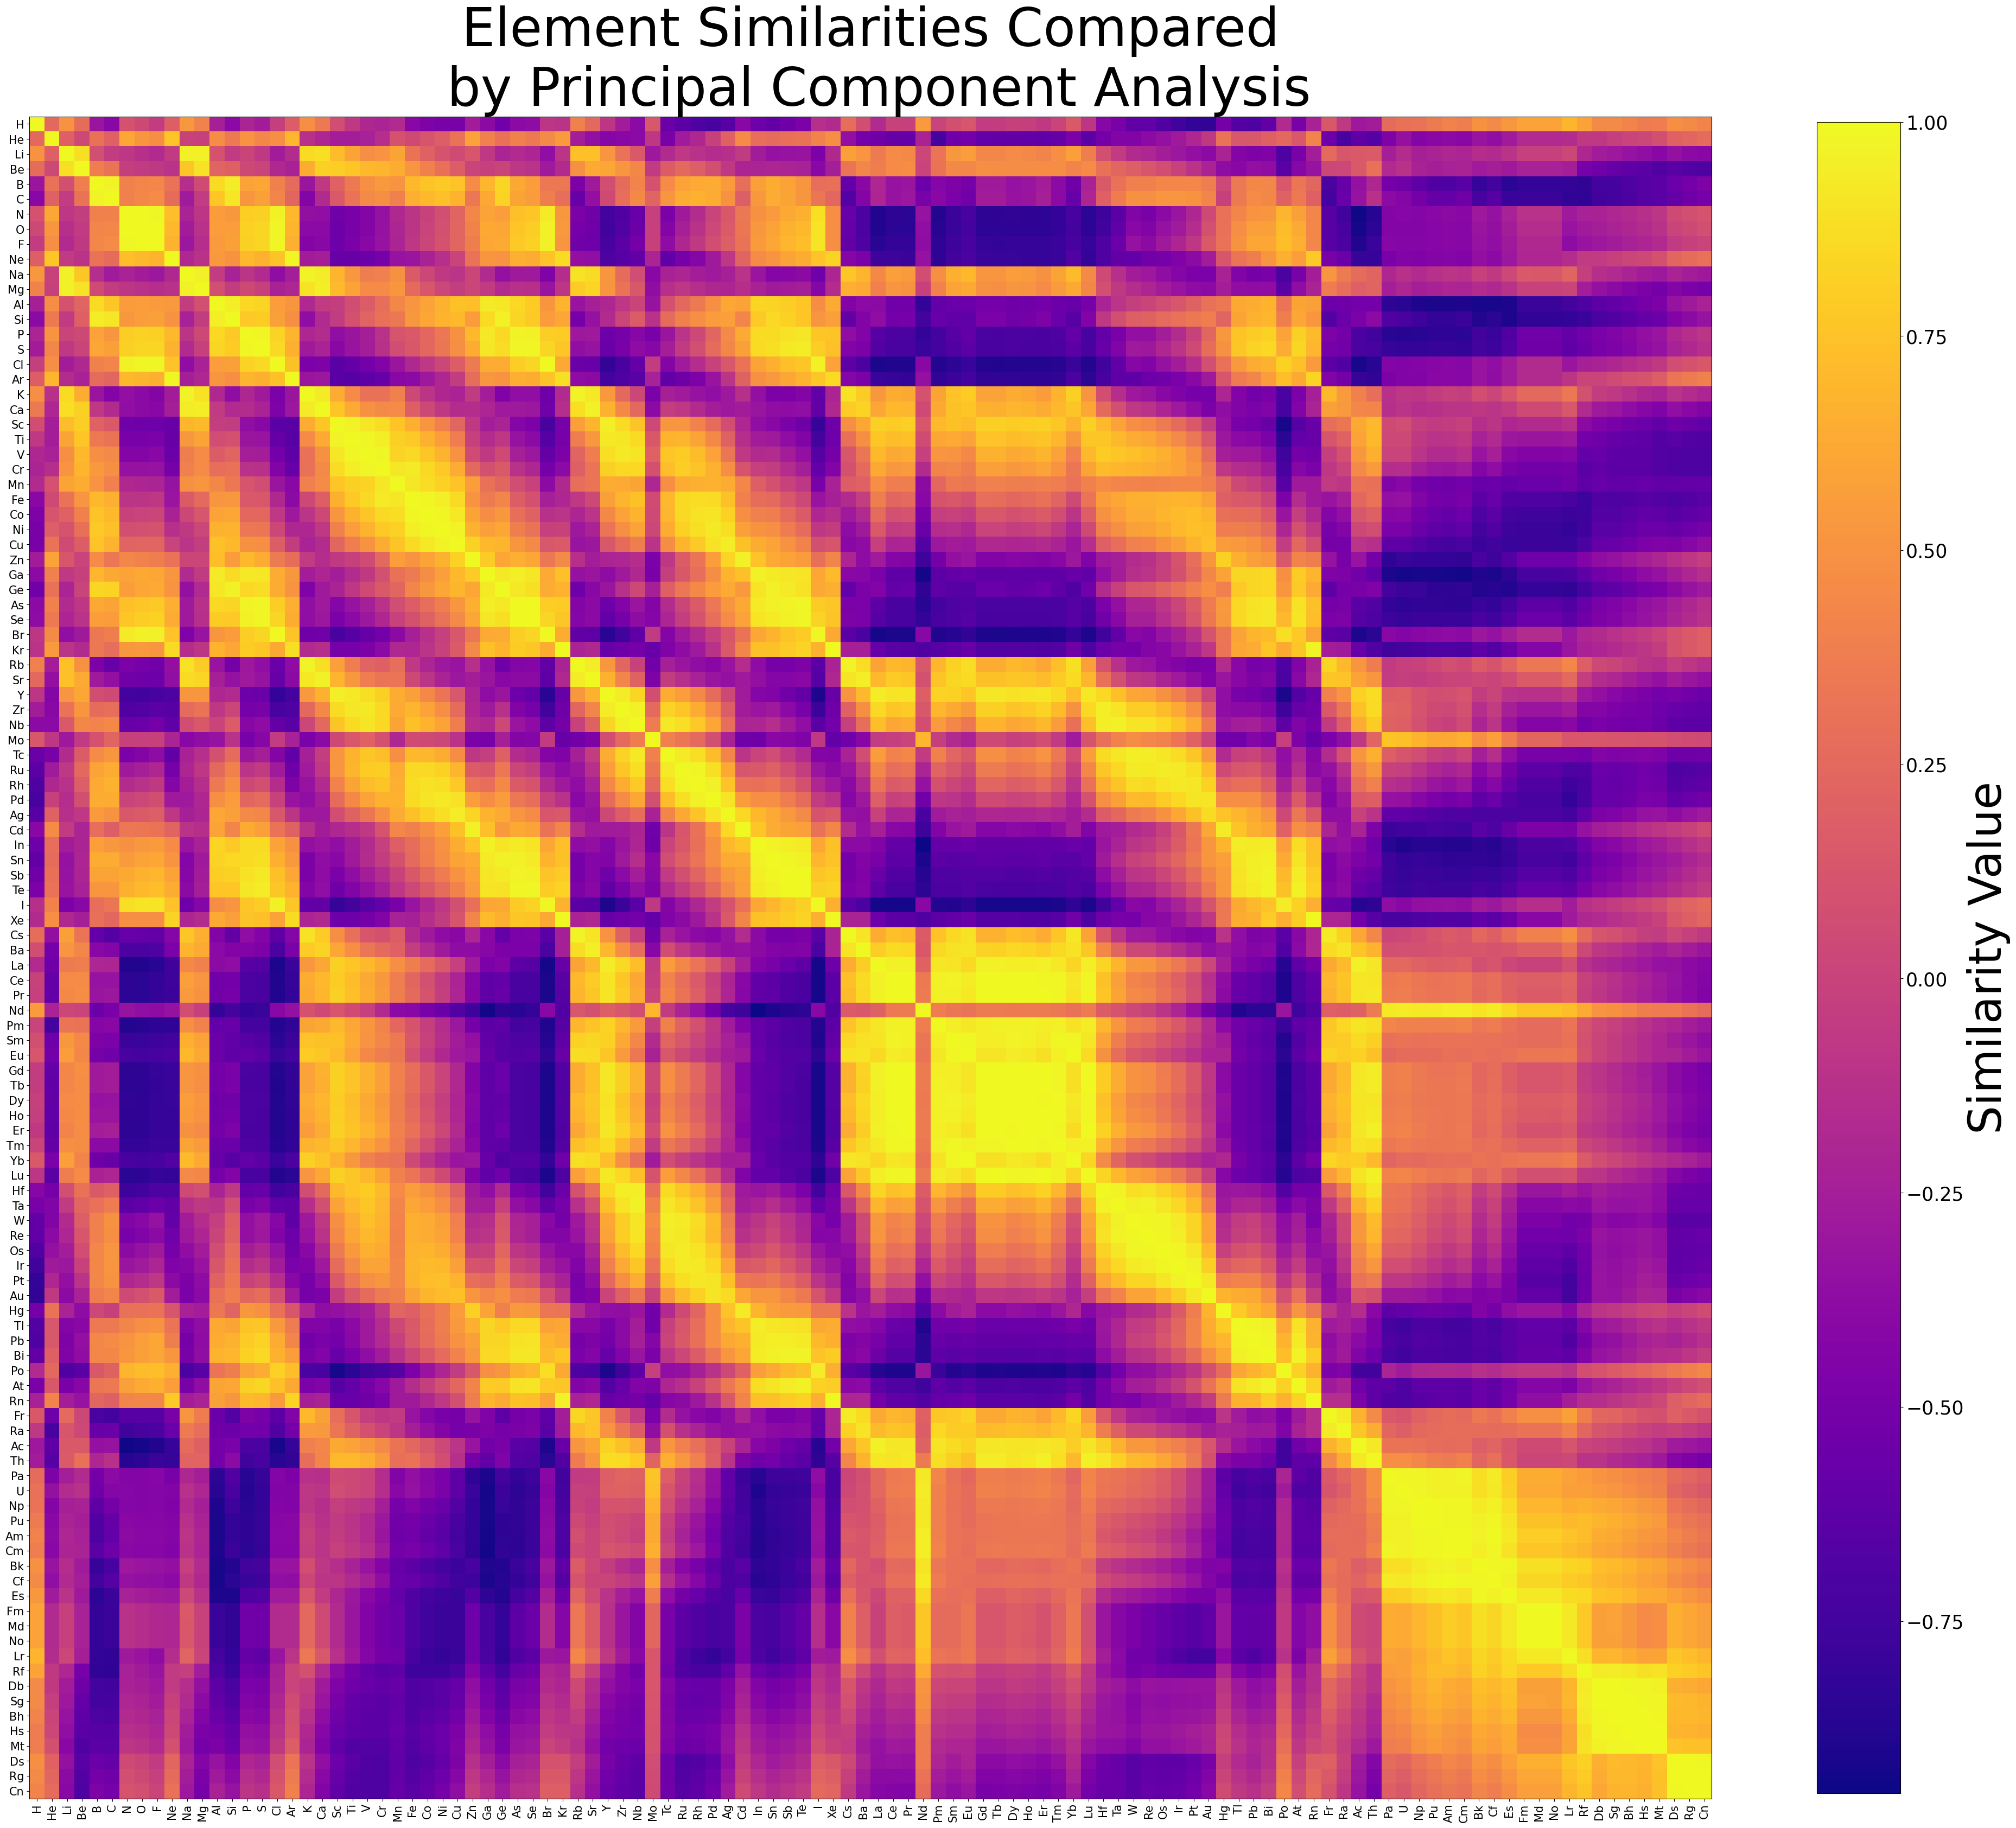

In [110]:
import matplotlib.pyplot as plt
import numpy as np

# Sample list of dictionaries
data = global_sorted_dict_list

# Extracting keys and values
keys = data[0].keys()
values = [[d[key] for key in keys] for d in data]

# Creating a heatmap
plt.figure(figsize=(50, 50))
heat_map = plt.imshow(values, cmap='plasma', interpolation='nearest')

# Adding labels
plt.title('Element Similarities Compared\n by Principal Component Analysis', fontsize = 70)
#plt.xlabel('Keys')
#plt.ylabel('Data Points')
plt.xticks(np.arange(len(keys)), keys,rotation = 90,fontsize = 15)
plt.yticks(np.arange(len(keys)), keys,fontsize = 15)
colorbar = plt.colorbar(heat_map,label='Values',shrink = 0.8)

colorbar.set_label('Similarity Value', fontsize=60,)
colorbar.ax.tick_params(labelsize=25)
# Displaying the heatmap
plt.show()


# <a name="section_b"></a>  Data Extraction
The training data used to train the WGANs model will be DFT data taken from Materials Project. As a proof of concept, the system selected for training is the Zr-Cu-Al system 
* Go back to [Outline](#outline)

In [30]:
os.chdir('/blue/hennig/sam.dong/GANs')

In [31]:
#############################################################
                # LOAD MP DATASET #
#############################################################

Load the structures from Materials Project. This make take several seconds... 

In [112]:
file_name = '/blue/hennig/sam.dong/GANs/materials_project_structures'
file_name_ase = '/blue/hennig/sam.dong/GANs/materials_project_ase'
with open(file_name,'rb') as file:
    pkl_structures = pickle.load(file)
    
with open(file_name_ase,'rb') as file2:
    pkl_ase = pickle.load(file2)
structures = pkl_structures
ase_atoms = pkl_ase

In [116]:
def extract_structures(structures_list,elem_list):
    """
    extract_structures:
    
    is a function that takes a list of pymatgen structure objects and a specified list of chemical symbols
    that you want to extract from the list of pymatgen structure objects. For example if elem_list is ['H','O'],
    this function will extract all structures in structures_list that have only hydrogen atoms, only oxygen atoms,
    or a combination of the two.
    
    Args:
        structures_list: a list of pymatgen structure objects
        
        elem_list: a list of strings that contain the chemical symbols you wish to extract from structures_list
        
    Returns:
        extracted_structures: a list of pymatgen structure objects that follow the compositional constraints 
        of elem_list.
    
    """    
    
    
    element_dict = {'H': 0, 'He': 1, 'Li': 2, 'Be': 3, 'B': 4, 'C': 5, 'N': 6, 'O': 7, 'F': 8, 'Ne': 9,
        'Na': 10, 'Mg': 11, 'Al': 12, 'Si': 13, 'P': 14, 'S': 15, 'Cl': 16, 'Ar': 17, 'K': 18,
        'Ca': 19, 'Sc': 20, 'Ti': 21, 'V': 22, 'Cr': 23, 'Mn': 24, 'Fe': 25, 'Co': 26, 'Ni': 27,
        'Cu': 28, 'Zn': 29, 'Ga': 30, 'Ge': 31, 'As': 32, 'Se': 33, 'Br': 34, 'Kr': 35, 'Rb': 36,
        'Sr': 37, 'Y': 38, 'Zr': 39, 'Nb': 40, 'Mo': 41, 'Tc': 42, 'Ru': 43, 'Rh': 44, 'Pd': 45,
        'Ag': 46, 'Cd': 47, 'In': 48, 'Sn': 49, 'Sb': 50, 'Te': 51, 'I': 52, 'Xe': 53, 'Cs': 54,
        'Ba': 55, 'La': 56, 'Ce': 57, 'Pr': 58, 'Nd': 59, 'Pm': 60, 'Sm': 61, 'Eu': 62, 'Gd': 63,
        'Tb': 64, 'Dy': 65, 'Ho': 66, 'Er': 67, 'Tm': 68, 'Yb': 69, 'Lu': 70, 'Hf': 71, 'Ta': 72,
        'W': 73, 'Re': 74, 'Os': 75, 'Ir': 76, 'Pt': 77, 'Au': 78, 'Hg': 79, 'Tl': 80, 'Pb': 81,
        'Bi': 82 ,'Po': 83,'At': 84,'Rn': 85,'Fr': 86,'Ra': 87,'Ac': 88,'Th': 89,'Pa': 90,'U': 91,'Np': 92,
        'Pu': 93,'Am': 94,'Cm': 95,'Bk': 96,'Cf': 97,'Es': 98,'Fm': 99,'Md': 100,'No': 101,'Lr': 102,'Rf': 103,'Db': 104,
        'Sg': 105,'Bh': 106,'Hs': 107,'Mt': 108,'Ds': 109,'Rg': 110,'Cn': 111,'Nh': 112,'Fl': 113,'Mc': 114,'Lv': 115,
        'Ts': 116,'Og': 117,'':100000}
    extracted_structures = []
    for structure in structures_list:
        periodic_numbers = list(structure.atomic_numbers)
        counter2 = 0
        for elem in elem_list:
            for atomic_number in periodic_numbers:
                if element_dict[elem]+1 == atomic_number:
                    counter2 = counter2 + 1
                else:
                    counter2 = counter2
        if counter2 == len(periodic_numbers):
            extracted_structures.append(structure)
    return extracted_structures

In [117]:
elem_list = ['Zr','Cu','Al']

In [118]:
materials_project_structures = extract_structures(structures,elem_list)

In [120]:
def filter_structures(structures_list,max_size,min_size):
    """
    filter_structures:
    
    is a function that takes in a list of pymatgen structure objects and filters that list by system size constraints
    
    Args:
        structures_list: a list of pymatgen structure objects
        
        max_size: an int which is the maximum size you want your system to be 
        
        min_size: an int which is the minimum size you want your system to be 
        
    Returns:
        filtered_structures: a list of pymatgen structure objects that follow the system_size constraints 
        of max_size and min_size.
    
    """    
    dim = []
    filtered_structures = []
    for i in structures_list:
        x = i.distance_matrix.shape[0]
        if x<=max_size and x> min_size:
            filtered_structures.append(i)
            dim.append(x)
    max_dim = max(dim)
    return filtered_structures 

In [123]:
filtered_structures = filter_structures(materials_project_structures,12,1)

In [125]:
#############################################################
                # DATA AGUMENTATION #
#############################################################

In [127]:
numbers = np.linspace(0, 360, 15)

In [128]:
# Rotate 
axes =[[1,0,0],[0,1,0],[0,0,1]]
numbers = np.linspace(0, 360, 15)

# Convert the numpy array to a regular Python list
angles = numbers.tolist()
rotated_data_set = []
counter = 0 
for filtered_structure in filtered_structures:
    for axis in axes:
        for angle in angles:
            rotation = RotationTransformation(axis, angle)
            rotated = rotation.apply_transformation(filtered_structures[counter])
            rotated_data_set.append(rotated)
    counter = counter+1

In [133]:
len(rotated_data_set)

1665

In [134]:
def create_species_list(structures_list):
    species_list = []
    for structure in structures_list:
        species = []
        for element in structure.species:
            symbol = str(element)
            species.append(symbol)
        species_list.append(species)
    return(species_list)

In [135]:
species_list = create_species_list(rotated_data_set)

# <a name="section_c"></a>  Featurization
The structures extracted from Materials Project will now be featurized into a modified version of the CrysTens representation. Here crystallographic information is encoded into the pixel values of an image.
* Go back to [Outline](#outline)

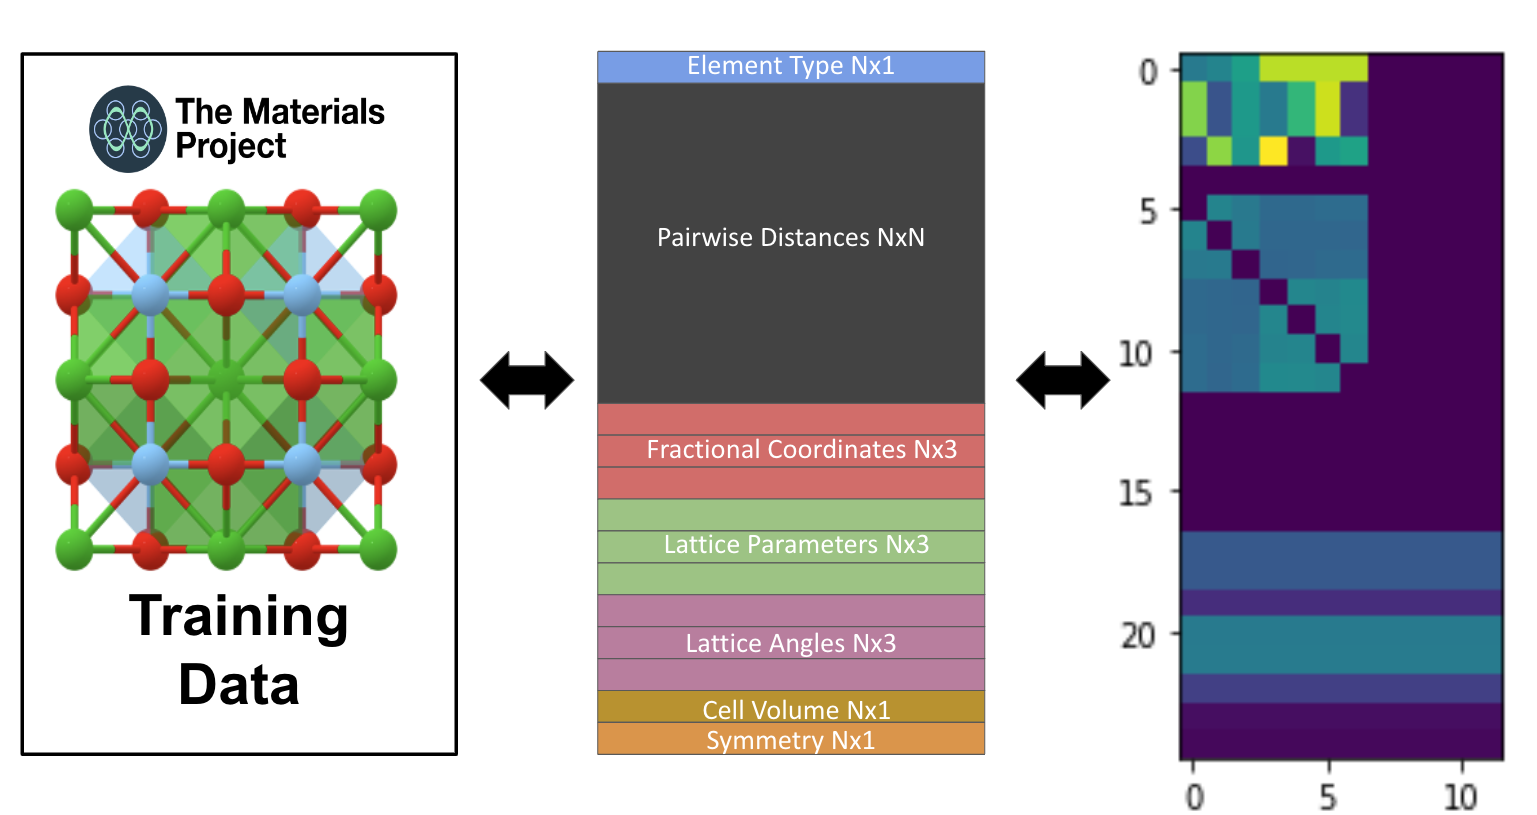

In [130]:
#############################################################
                # CREATE THE IMAGE #
#############################################################

In [131]:
class PNGrepresentation:
    
    """
    PNGrepresentation:
    
    contains all functions needed to convert a pymatgen structure object into an image representation.
    
        create_pairwise_distance: function that extracts pairwise distance matrices and converts into 
        NxN numpy array
        
        alternative_atomic_numbers2: function that encodes PCA element rankings into numpy arrays 
        1xN numpy array
        
        add_fractional_coordinates: function that extracts fractional coordinate matrices and converts into 3xN
        numpy arrays 
        
        add_cartesian_coordinates: function that extracts cartesian coordinate matrices and converts into 3xN
        numpy array
        
        add_abc: function that extracts lattice parameters and converts into a 1xN numpy array
        
        add_angles: function that extracts lattice angles and converts into a 1xN numpy array
        
        add_volume: function that extracts cell volume and converts into a 1xN numpy array
        
        compile_png: function that takes the outputs of the above functions and compiles into a single 
        modified CrysTens representation which will be used to train our model. 
    """  
    
    
    def create_pairwise_distance(self,structures):
    """
    create_pairwise_distance:
    
    function that extracts pairwise distance matrices and converts into an NxN numpy array
    
    Args:
        structures: a list of pymatgen structure objects
        
    Returns:
        padded_distance_mats: a list of NxN pairwise distance matrices where N is the maximum number of atoms 
        in your training data. If a given structure is less than N, the pairwise distance matrix is padded with 
        zeros. 
        
        max_dim: is the maximum dimension of the pairwise distance matrices. It is constrained to N. 
    
    """  
        distance_mats = []
        dim_mat = []
        for structure in structures:
            distance_mat = structure.distance_matrix*15
            distance_mats.append(distance_mat)
            dim = structure.distance_matrix.shape[0]
            dim_mat.append(dim)
        max_dim = max(dim_mat)
        padded_distance_mats = []
        ones_list = [1,1,1,1,1,1]
        for ones in ones_list:
            if max_dim%3 == 0:
                max_dim = max_dim
            else:
                max_dim = max_dim+1
        # add padding to each distance matrix:
        for dis_mat in distance_mats:
            rows_padding = max_dim-dis_mat.shape[0]
            
            cols_padding = max_dim-dis_mat.shape[1]
            padded_distance_mat = np.pad(dis_mat,((0,rows_padding),(0,cols_padding)),mode = 'constant')
            padded_distance_mats.append(padded_distance_mat) 
        print(padded_distance_mats[0].shape)
        return padded_distance_mats,max_dim
    
    
    def alternative_atomic_numbers2(self,structures,max_dim):
    """
    alternative_atomic_numbers2: function that encodes PCA element rankings into numpy arrays 
    1xN numpy array
    
    Args:
        structures: a list of pymatgen structure objects
        
        max_dim: is the maximum dimension of the pairwise distance matrices. It is constrained to N.  
        
    Returns:
        alternative_atomic_pngs: a list of 1xN numpy arrays that contain the elements encoded in the pixel values
    
    """ 
        
        elements = ['placeholder','H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 
                    'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 
                    'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 
                    'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 
                    'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 
                    'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 
                    'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg', 
                    'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn']
        
        elements_dict = {
'H': 40, 'Li': 45, 'Na': 50, 'K': 55, 'Rb': 60, 'Cs': 65, 'Fr': 70, 'Be': 120, 'Mg': 125, 'Ca': 130,
 'Sr': 135, 'Ba': 140, 'Ra': 145, 'Sc': 195, 'Y': 200, 'La': 205, 'Ce': 210, 'Pr': 215, 'Nd': 220, 'Pm': 225,
 'Sm': 230, 'Eu': 235, 'Gd': 240, 'Tb': 245, 'Dy': 250, 'Ho': 255, 'Er': 260, 'Tm': 265, 'Yb': 270, 'Lu': 275,
 'Ac': 280, 'Th': 285, 'Pa': 290, 'U': 295, 'Np': 300, 'Pu': 305, 'Am': 310, 'Cm': 315, 'Bk': 320, 'Cf': 325,
 'Es': 330, 'Fm': 335, 'Md': 340, 'No': 345, 'Lr': 350, 'Ti': 360, 'Zr': 365, 'Hf': 370, 'V': 380, 'Nb': 385,
 'Ta': 390, 'Cr': 400, 'Mo': 405, 'W': 410, 'Mn': 420, 'Tc': 425, 'Re': 430, 'Fe': 440, 'Ru': 445, 'Os': 450,
 'Co': 460, 'Rh': 465, 'Ir': 470, 'Ni': 480, 'Pd': 485, 'Pt': 490, 'Cu': 500, 'Ag': 505, 'Au': 510, 'Zn': 520,
 'Cd': 525, 'Hg': 530, 'B': 580, 'Al': 585, 'Ga': 590, 'In': 595, 'Tl': 600, 'C': 650, 'Si': 655, 'Ge': 660,
 'Sn': 665, 'Pb': 670, 'N': 720, 'P': 725, 'As': 730, 'Sb': 735, 'Bi': 740, 'O': 790, 'S': 795, 'Se': 800,
 'Te': 805, 'Po': 810, 'F': 860, 'Cl': 865, 'Br': 870, 'I': 875, 'At': 880, 'He': 930, 'Ne': 935, 'Ar': 940,
 'Kr': 945, 'Xe': 950, 'Rn': 955
}
        
        alternative_atomic_pngs = []
        
        for structure in structures:
            atomic_numbers_arr = structure.atomic_numbers
            elements_list = [elements[atomic_number] for atomic_number in atomic_numbers_arr]
            atomic_numbers_arr = [elements_dict[elem] for elem in elements_list]
            
            padded_atomic_numbers = list(atomic_numbers_arr) + list(np.zeros(max_dim-len(atomic_numbers_arr)))
            alternative_atomic_pngs.append(padded_atomic_numbers)
        return np.array(alternative_atomic_pngs)*0.1
        
            
        

    def add_fractional_coordinates(self,structure_list,max_dim):
        
    """
    add_fractional_coordinates: function that extracts fractional coordinate matrices and converts into 3xN
    numpy arrays  
    
    Args:
        structure_list: a list of pymatgen structure objects
        
        max_dim: is the maximum dimension of the pairwise distance matrices. It is constrained to N.  
        
    Returns:
        x_frac: a 1xN padded array of fractional coordinates in the x-direction 
        y_frac: a 1xN padded array of fractional coordinates in the y-direction 
        z_frac: a 1xN padded array of fractional coordinates in the z-direction 
    
    """ 
        coords_list = []
        for structure in structure_list:
            car = structure.frac_coords*125
            coords_list.append(car) 
        # extract x, y, z coordinates 
        x_frac = []
        y_frac = []
        z_frac = []
        for coord in coords_list:
            x_coords = []
            y_coords = []
            z_coords = []
            for coordinates in coord:
                x_coords.append(coordinates[0])
                y_coords.append(coordinates[1])
                z_coords.append(coordinates[2])
            x_coords = x_coords + list(np.zeros(max_dim-len(x_coords)))
            y_coords = y_coords + list(np.zeros(max_dim-len(y_coords)))
            z_coords = z_coords + list(np.zeros(max_dim-len(z_coords)))
            x_frac.append(x_coords)
            y_frac.append(y_coords)
            z_frac.append(z_coords)

        return x_frac,y_frac,z_frac
    
    
    def add_cartesian_coordinates(self,structure_list,max_dim):
    """
    add_cartesian_coordinates: function that extracts cartesian coordinate matrices and converts into 3xN
    numpy arrays  
    
    Args:
        structure_list: a list of pymatgen structure objects
        
        max_dim: is the maximum dimension of the pairwise distance matrices. It is constrained to N.  
        
    Returns:
        x_frac: a 1xN padded array of cartesian coordinates in the x-direction 
        y_frac: a 1xN padded array of cartesian coordinates in the y-direction 
        z_frac: a 1xN padded array of cartesian coordinates in the z-direction 
    
    """ 
        coords_list = []
        for structure in structure_list:
            car = structure.cart_coords*10
            coords_list.append(car) 
        # extract x, y, z coordinates 
        x_cart = []
        y_cart = []
        z_cart = []
        for coord in coords_list:
            x_coords = []
            y_coords = []
            z_coords = []
            for coordinates in coord:
                x_coords.append(coordinates[0])
                y_coords.append(coordinates[1])
                z_coords.append(coordinates[2])
            x_coords = x_coords + list(np.zeros(max_dim-len(x_coords)))
            y_coords = y_coords + list(np.zeros(max_dim-len(y_coords)))
            z_coords = z_coords + list(np.zeros(max_dim-len(z_coords)))
            x_cart.append(x_coords)
            y_cart.append(y_coords)
            z_cart.append(z_coords)

        return x_cart,y_cart,z_cart
    
    def add_abc(self,structure_list,max_dim):
    """
    add_abc: function that extracts lattice parameters and converts into a 1xN numpy array
    
    Args:
        structure_list: a list of pymatgen structure objects
        
        max_dim: is the maximum dimension of the pairwise distance matrices. It is constrained to N.  
        
    Returns:
        png_a: a 1xN padded array of the a lattice parameter 
        png_b: a 1xN padded array of the b lattice parameter 
        png_c: a 1xN padded array of the c lattice parameter  
    
    """     
        abc_list = []
        a_list = []
        b_list = []
        c_list = []
        for structure in structure_list:
            abcs = list(structure.lattice.abc)
            a_list.append(abcs[0])
            b_list.append(abcs[1])
            c_list.append(abcs[2])
        a_list = a_list
        b_list = b_list
        c_list = c_list
        
        a_pngs = []
        b_pngs = []
        c_pngs = []
        for count in range(0,len(a_list)):
            a_png = a_list[count]+np.zeros(max_dim)
            b_png = b_list[count]+np.zeros(max_dim)
            c_png = c_list[count]+np.zeros(max_dim)
            a_pngs.append(a_png)
            b_pngs.append(b_png)
            c_pngs.append(c_png)
        
        png_a = np.array(a_pngs)*10
        png_b = np.array(b_pngs)*10
        png_c = np.array(c_pngs)*10
        
        return png_a,png_b,png_c
    
    def add_angles(self,structure_list,max_dim):
    """
    add_angles: function that extracts lattice angles and converts into a 1xN numpy array
    
    Args:
        structure_list: a list of pymatgen structure objects
        
        max_dim: is the maximum dimension of the pairwise distance matrices. It is constrained to N.  
        
    Returns:
        png_alpha: a 1xN padded array of the alpha lattice angle 
        png_beta: a 1xN padded array of the beta lattice angle
        png_gamma: a 1xN padded array of the gamma lattice angle 
    
    """ 
        alpha_list = []
        beta_list = []
        gamma_list = []
        angles_list = []
        for structure in structure_list:
            angles = list(structure.lattice.angles)
            alpha_list.append(angles[0])
            beta_list.append(angles[1])
            gamma_list.append(angles[2])
        alpha_pngs = []
        beta_pngs = []
        gamma_pngs = []
        for count in range(0,len(alpha_list)):
            alpha_png = alpha_list[count]+np.zeros(max_dim)
            beta_png = beta_list[count]+np.zeros(max_dim)
            gamma_png = gamma_list[count]+np.zeros(max_dim)
            alpha_pngs.append(alpha_png)
            beta_pngs.append(beta_png)
            gamma_pngs.append(gamma_png)
        png_alpha = np.array(alpha_pngs)
        png_beta = np.array(beta_pngs)
        png_gamma = np.array(gamma_pngs)
        return png_alpha,png_beta,png_gamma
    
    def add_volume(self,structure_list,max_dim):
    """
    add_volume: function that extracts cell volume and converts into a 1xN numpy array
    
    Args:
        structure_list: a list of pymatgen structure objects
        
        max_dim: is the maximum dimension of the pairwise distance matrices. It is constrained to N.  
        
    Returns:
        png_volumes: a list of 1xN numpy arrays that contain the cell volumes of structure_list
    
    """ 
        volumes = []
        for structure in structure_list:
            volume = structure.volume/5
            #print(volume)
            volumes.append(volume)
        png_volumes = []
        for volume in volumes:
            png_volume = np.zeros(max_dim)+volume
            png_volumes.append(png_volume)
        return png_volumes
            
    
    def compile_png(self,structure_list,soap_png,atomic_png,x_png,y_png,z_png,a_png,b_png,c_png,alpha_png,beta_png,gamma_png,volume_png,max_dim):
    """
    compile_png: function that takes the outputs of the above functions and compiles into a single 
    modified CrysTens representation which will be used to train our model.
        
    Args:
        structure_list: a list of pymatgen structure objects
        
        soap_png: 
        
        atomic_png: list returned from alternative_atomic_pngs2
        
        x_png: list returned from either extract_fractional_coordinates or extract_cartesian_coordinates
        
        y_png: list returned from either extract_fractional_coordinates or extract_cartesian_coordinates
        
        z_png: list returned from either extract_fractional_coordinates or extract_cartesian_coordinates
        
        a_png: list return from add_abc
        
        b_png: list returned from add_abc
        
        c_png: list returned from add_abc
        
        alpha_png: list returned from add_angles
        
        beta_png: list returned from add_angles
        
        gamma_png: list returned from add_angles
        
        volume_png: list returned from add_volume
        
        max_dim: is the maximum dimension of the pairwise distance matrices. It is constrained to N.  
        
    Returns:
        stacked_png_ys: a list of numpy arrays that take out the global symmetry of the descriptor
        
        completed_pngs: a list of numpy arrays that have the full symmetry of the descriptor. 
    
    """ 
        
        stacked_png_ys = []
        for counter in range(0,len(structure_list)):
            stacked_png_y = np.concatenate((atomic_png[counter].reshape(1,max_dim),np.array(x_png[counter]).reshape(1,max_dim),
                                           np.array(y_png[counter]).reshape(1,max_dim),np.array(z_png[counter]).reshape(1,max_dim),
                                           np.array(a_png[counter]).reshape(1,max_dim),np.array(b_png[counter]).reshape(1,max_dim),
                                           np.array(c_png[counter]).reshape(1,max_dim),np.array(alpha_png[counter]).reshape(1,max_dim),
                                           np.array(beta_png[counter]).reshape(1,max_dim),np.array(gamma_png[counter]).reshape(1,max_dim),
                                           np.array(volume_png[counter]).reshape(1,max_dim),soap_png[counter]), axis = 0)
            stacked_png_ys.append(stacked_png_y)
        new_atomics = []
        new_xs = []
        new_ys = []
        new_zs = []
        new_as = []
        new_bs = []
        new_cs = []
        new_alphas = []
        new_betas = []
        new_gammas = []
        new_volumes = []
        
        
        
        for counter in range(0,len(structure_list)):
            #new_atomic = np.hstack((np.zeros(((stacked_png_ys[0].shape[0]-max_dim),3)),atomic_png[counter]))
            new_atomic = atomic_png[counter]
            new_x = np.concatenate((np.zeros(stacked_png_ys[0].shape[0]-max_dim),np.array(x_png[counter])),axis = 0)
            new_y = np.concatenate((np.zeros(stacked_png_ys[0].shape[0]-max_dim),np.array(y_png[counter])),axis = 0)
            new_z = np.concatenate((np.zeros(stacked_png_ys[0].shape[0]-max_dim),np.array(z_png[counter])),axis = 0)
            new_a = np.concatenate((np.zeros(stacked_png_ys[0].shape[0]-max_dim),np.array(a_png[counter])),axis = 0)
            new_b = np.concatenate((np.zeros(stacked_png_ys[0].shape[0]-max_dim),np.array(b_png[counter])),axis = 0)
            new_c = np.concatenate((np.zeros(stacked_png_ys[0].shape[0]-max_dim),np.array(c_png[counter])),axis = 0)
            new_alpha = np.concatenate((np.zeros(stacked_png_ys[0].shape[0]-max_dim),np.array(alpha_png[counter])),axis = 0)
            new_beta = np.concatenate((np.zeros(stacked_png_ys[0].shape[0]-max_dim),np.array(beta_png[counter])),axis = 0)
            new_gamma = np.concatenate((np.zeros(stacked_png_ys[0].shape[0]-max_dim),np.array(gamma_png[counter])),axis = 0)
            new_volume= np.concatenate((np.zeros(stacked_png_ys[0].shape[0]-max_dim),np.array(volume_png[counter])),axis = 0)
            new_atomics.append(new_atomic)
            new_xs.append(new_x)
            new_ys.append(new_y)
            new_zs.append(new_z)
            new_as.append(new_a)
            new_bs.append(new_b)
            new_cs.append(new_c)
            new_alphas.append(new_alpha)
            new_betas.append(new_beta)
            new_gammas.append(new_gamma)
            new_volumes.append(new_volume)
        
            
        completed_pngs = []
        
        pad = stacked_png_ys[0].shape[0]
    
    
        for counter in range(0,len(structure_list)):
            completed_pic = np.concatenate((new_xs[counter].reshape(pad,1),new_ys[counter].reshape(pad,1)
                                            ,new_zs[counter].reshape(pad,1),new_as[counter].reshape(pad,1),new_bs[counter].reshape(pad,1)
                                            ,new_cs[counter].reshape(pad,1),new_alphas[counter].reshape(pad,1),new_betas[counter].reshape(pad,1)
                                            ,new_gammas[counter].reshape(pad,1),new_volumes[counter].reshape(pad,1),stacked_png_ys[counter]),axis = 1)
            #completed_png = np.vstack((new_atomics[counter],completed_pic))
            completed_pngs.append(completed_pic)
        
        return stacked_png_ys,completed_pngs
        

In [137]:
obj = PNGrepresentation()

In [138]:
imgs = rotated_data_set

In [139]:
pairwise_angles_png,max_dim = obj.create_pairwise_angles(imgs,[1,0,0])

(12, 12)


/scratch/local/26453297/ipykernel_1774358/813781502.py:60: RuntimeWarning: invalid value encountered in divide
  cosine_angles = dot_products / (magnitudes * reference_magnitude)


In [140]:
species_list = create_species_list(imgs)

In [141]:
pwd_png,max_dim = obj.create_pairwise_distance(imgs)

(12, 12)


In [142]:

alternative_atomic_png = obj.alternative_atomic_numbers2(imgs,max_dim)

In [143]:
alternative_atomic_png[320].shape

(12,)

In [144]:
x_frac_png,y_frac_png,z_frac_png = obj.add_fractional_coordinates(imgs,max_dim)

In [145]:
a_png,b_png,c_png = obj.add_abc(imgs,max_dim)

In [146]:
alpha_png,beta_png,gamma_png = obj.add_angles(imgs,max_dim)

In [147]:
volume_png = obj.add_volume(imgs,max_dim)

In [148]:
completed_ys,completed_pngs = obj.compile_png(imgs,pwd_png,alternative_atomic_png,x_frac_png,y_frac_png,z_frac_png,a_png,b_png,c_png,alpha_png,beta_png,gamma_png,volume_png,max_dim)

In [184]:
# align pwd matrix with fractional coordinates: 
final_images = []
for completed_y in completed_ys:
    pwd = completed_y[-12:]
    zeros = np.zeros(12)
    new_arr = np.insert(arr,4,zeros,axis = 0)
    new_arr = np.insert(new_arr,5,pwd,axis = 0)
    final_images.append(new_arr[:-12])

## An example of a featurized image of Zr2Al2

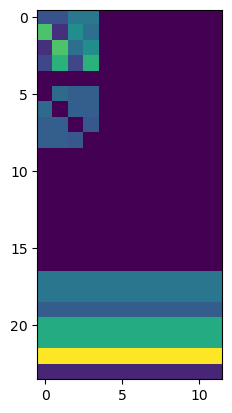

In [185]:
plt.imshow(final_images[0])

In [532]:
normalized_truncated_pngs = [(i/max(i.reshape(truncated_pngs[0].shape[0]*truncated_pngs[0].shape[1],))) for i in truncated_pngs]




# <a name="section_d"></a>  The Wasserstein Generative Adversarial Network
A Wasserstein generative adversarial network was the generative model chosen. Here two neural networks, a generator and critic are trained simultaneously in a competitive training process. The main goal of the generator is to produce realistic images that will grant a high score from the critic. The critic network uses the Wasserstein distance as a metric to assign scores of realness. 
* Go back to [Outline](#outline)

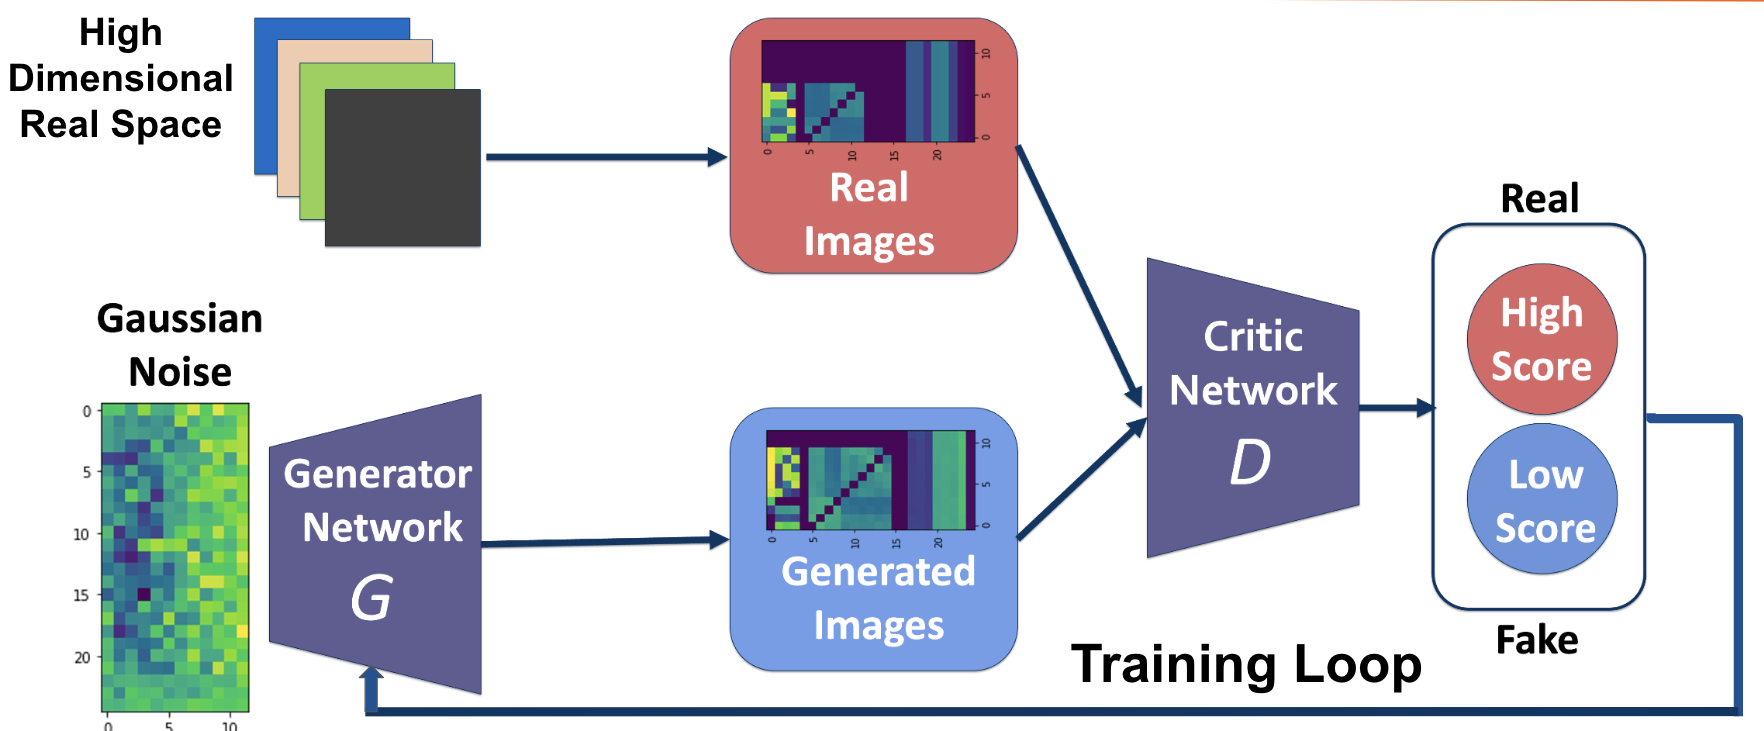

In [190]:
def build_generator():
    model = Sequential()
    png_dim1 = final_images[0].shape[0]
    png_dim2 = final_images[0].shape[1]
    input_dim = 28
    # Takes in random values and reshapes it to 940x1 array
    # Beginnings of a generated image
    model.add(Dense(png_dim1*png_dim2*input_dim, input_dim=input_dim))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((png_dim1,png_dim2,input_dim)))


    #Upsampling block 1
    #model.add(UpSampling2D())
    model.add(Conv2D(64,5,1, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    #model.add(UpSampling2D())
    model.add(Conv2D(64,5,1, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 3
    #model.add(UpSampling2D())
    model.add(Conv2D(64,4,1, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 1
    #model.add(UpSampling2D())
    model.add(Conv2D(64,4,1, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 2
    model.add(Conv2D(64,3,1, padding='same'))
    model.add(LeakyReLU(0.5))

    # Convolutional block 2
    model.add(Conv2D(64,3,1, padding='same'))
    model.add(LeakyReLU(0.5))



    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    #model.add(Reshape((940,)))
    #model.add(Dense(940))



    return model

In [191]:
generator = build_generator()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8064)              233856    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8064)              0         
                                                                 
 reshape (Reshape)           (None, 24, 12, 28)        0         
                                                                 
 conv2d (Conv2D)             (None, 24, 12, 64)        44864     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 24, 12, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 12, 64)        102464    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 24, 12, 64)       

In [195]:
# FOR 12 ELEMENT SYSTEM
def build_discriminator():
    model = Sequential()

    png_dim1 =  final_images[0].shape[0]

    png_dim2 =  final_images[0].shape[1]
    
    filters = 128

    # First Conv Block
    model.add(Conv2D(filters, 4, input_shape = (png_dim1,png_dim2,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second Conv Block
    model.add(Conv2D(filters*2, 4))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Third Conv Block
    model.add(Conv2D(filters*2, 3))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #Fourth Conv Block
    model.add(Conv2D(filters*2, 3))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #Fifth Conv Block
    model.add(Conv2D(filters*3, 1))
    model.add(LeakyReLU(0.5))
    model.add(Dropout(0.4))

    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(tf.keras.layers.Activation('linear'))
    model.add(Dropout(0.4))
    model.add(Dense(1))

    return model

In [196]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 21, 9, 128)        2176      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 21, 9, 128)        0         
                                                                 
 dropout_5 (Dropout)         (None, 21, 9, 128)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 18, 6, 256)        524544    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 18, 6, 256)        0         
                                                                 
 dropout_6 (Dropout)         (None, 18, 6, 256)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 4, 256)       

In [197]:
real_images = np.array(final_images)
max_pixel_value = max(np.max(image) for image in real_images)
norm_pngs = np.array(real_images)/max_pixel_value

In [200]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [201]:
gpus

[]

In [202]:
if gpus:
    gpu_to_use = '/device:GPU:0'
    with tf.device(gpu_to_use):
        class GANS(Model):
            def __init__(self,generator,discriminator,*args,**kwargs):
                super().__init__(*args,**kwargs)
                self.generator = generator
                self.discriminator = discriminator
            def compile(self,g_opt,d_opt,g_loss,d_loss,*args,**kwargs):
                super().compile(*args,**kwargs)
                self.g_opt = g_opt
                self.d_opt = d_opt
                self.g_loss = g_loss
                self.d_loss = d_loss
            def wasserstein_distance_loss(self,real_output, fake_output):
                print('fake_output:',tf.reduce_mean(fake_output))
                print('real_output',tf.reduce_mean(real_output))
                return (tf.reduce_mean(abs(fake_output)) - tf.reduce_mean(abs(real_output))) #+ tf.constant(1.0, dtype=tf.float32)
            def generator_loss(self,fake_output):
                #tf.enable_eager_execution()
                print(-tf.reduce_mean(fake_output))
                return -tf.reduce_mean(abs(fake_output)) #- np.log(symmetry_score)*100#*0.5
            def gradient_penalty(self,batch,real_output,fake_output):
                #max_pixel_value = max(np.max(image) for image in np.array(real_output))
                max_pixel_value = 1
                #print('real shape:',real_output.shape)
                input_dim = 35
                #alpha = tf.random.normal([batch,input_dim,input_dim,1],0.0,1.0)
                alpha = tf.random.normal([batch,1,1,1],0.0,1.0)
                #print('alpha shape:',alpha.shape)
                diff = fake_output - (real_output/max_pixel_value)
                #print('diff_shape:',diff.shape)
                #print('diff_type:',type(diff))
                interpolated = (real_output/max_pixel_value) + alpha * diff 
                #print('interpolated_shape:',interpolated.shape)
                with tf.GradientTape() as gp_tape:
                    gp_tape.watch(interpolated)
                    pred = self.discriminator(interpolated,training = True)
                grads = gp_tape.gradient(pred,[interpolated])[0]
                norm = tf.sqrt(tf.reduce_sum(tf.square(grads),axis = [1,2,3]))
                gp = tf.reduce_mean((norm - 1.0)**2)
                return grads,norm,gp,pred,diff,interpolated
            def train_step(self,batch):
                input_dim = 28
                switch = 'Both'
                batch_size = 1024  #batch.shape
                real_images = batch
                with tf.GradientTape() as d_tape:
                    #####################################
                    fake_images = self.generator(tf.random.normal((batch_size,input_dim,1)),training = True)
                    #####################################
                    yhat_real = self.discriminator((real_images), training=True) 
                    yhat_fake = self.discriminator((fake_images), training=True)
                    yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
                    y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

                    noise_real = 0.3*tf.random.normal(tf.shape(yhat_real))
                    noise_fake = -0.3*tf.random.normal(tf.shape(yhat_fake))
                    y_realfake += tf.concat([noise_real, noise_fake], axis=0)
                    d_loss = self.wasserstein_distance_loss(yhat_real, yhat_fake)
                    gp_grads,gp_norm,gp,pred,diff,interpolated = self.gradient_penalty(batch_size,real_images,fake_images)
                    total_d_loss = d_loss + gp
                    combined_d_loss = total_d_loss #+ total_d_loss2
                ##########################################################################
                dgrad = d_tape.gradient(combined_d_loss, self.discriminator.trainable_variables)
                ##########################################################################
                self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
                with tf.GradientTape() as g_tape: 
                    # Generate some new images
                    gen_images = self.generator(tf.random.normal((batch_size,input_dim,1)), training=True)                      
                    # Create the predicted labels
                    predicted_labels = self.discriminator(gen_images, training=True)                
                    total_g_loss = self.generator_loss(predicted_labels) #+ np.log(symmetry_score)*15
                ggrad = g_tape.gradient(combined_g_loss, self.generator.trainable_variables)
                self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
                return {"d_loss":total_d_loss, "g_loss":total_g_loss,'fake_output':yhat_fake,'real_output':yhat_real,'predicted_labels':predicted_labels}

In [203]:
os.chdir('/blue/hennig/sam.dong/GANs/gans_scripts/nvvm/libdevice')

In [204]:
g_opt = tf.keras.optimizers.RMSprop(learning_rate = 0.00007)
d_opt = tf.keras.optimizers.RMSprop(learning_rate = 0.00007)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [205]:
generator = build_generator()
discriminator = build_discriminator()

In [206]:
gans = GANS(generator,discriminator)

NameError: name 'GANS' is not defined

In [ ]:
gans.compile(g_opt,d_opt,g_loss ,d_loss)

In [42]:
# class ModelMonitor(Callback):
def __init__(self, num_img=3, latent_dim=64):
    self.num_img = num_img
    self.latent_dim = latent_dim

def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
    generated_images = self.model.generator(random_latent_vectors)
    #generated_images *= 255
    generated_images.numpy()
    for i in range(self.num_img):
        img = array_to_img(generated_images[i])
        img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [45]:
batch_size = 1024
max_steps = int(len(norm_pngs[0:500000])/batch_size)
num_steps = max_steps
data_size = num_steps*batch_size
data_size

499712

In [46]:
batch1 = np.array(norm_images).reshape((len(norm_images),np.array(norm_images).shape[1],
                                                  np.array(norm_images).shape[2],1))[0:data_size]

In [48]:
hist = gans.fit(batch1,
                epochs=75,
                batch_size = batch_size)

Epoch 1/75
Tensor("IteratorGetNext:0", shape=(1024, 25, 12, 1), dtype=float32)
yhat_real type: <class 'tensorflow.python.framework.ops.Tensor'>
fake_output: Tensor("Mean:0", shape=(), dtype=float32)
real_output Tensor("Mean_1:0", shape=(), dtype=float32)
Tensor("Neg:0", shape=(), dtype=float32)
Tensor("IteratorGetNext:0", shape=(1024, 25, 12, 1), dtype=float32)
yhat_real type: <class 'tensorflow.python.framework.ops.Tensor'>
fake_output: Tensor("Mean:0", shape=(), dtype=float32)
real_output Tensor("Mean_1:0", shape=(), dtype=float32)
Tensor("Neg:0", shape=(), dtype=float32)


2024-01-18 12:40:22.029663: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


488/488 [==============================] - 51s 96ms/step - d_loss: -2.7714 - g_loss: -4.2726 - fake_output: 4.4308 - real_output: 8.3083 - predicted_labels: 4.1423
Epoch 2/75
488/488 [==============================] - 47s 96ms/step - d_loss: -1.0972 - g_loss: -5.2557 - fake_output: 5.3572 - real_output: 6.7321 - predicted_labels: 5.2524
Epoch 3/75
488/488 [==============================] - 47s 96ms/step - d_loss: -0.4094 - g_loss: -6.6172 - fake_output: 6.6850 - real_output: 7.1456 - predicted_labels: 6.6149
Epoch 4/75
488/488 [==============================] - 47s 96ms/step - d_loss: -0.3769 - g_loss: -8.9657 - fake_output: 9.0025 - real_output: 9.4243 - predicted_labels: 8.9639
Epoch 5/75
488/488 [==============================] - 47s 96ms/step - d_loss: -0.3048 - g_loss: -8.1508 - fake_output: 8.2194 - real_output: 8.5613 - predicted_labels: 8.1498
Epoch 6/75
488/488 [==============================] - 47s 96ms/step - d_loss: -0.3070 - g_loss: -8.8249 - fake_output: 8.8607 - real_out

In [ ]:
gen_images3 = generator(tf.random.normal((100000,28,1)), training=True)

2024-01-18 15:00:34.558692: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


## Examples of novel images generated by the WGANs network that can be decoded to their original POSCAR files. 

100


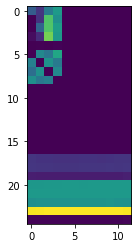

101


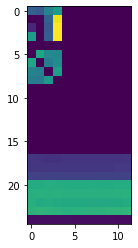

102


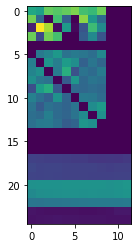

103


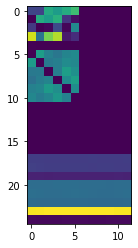

104


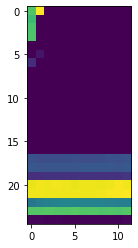

105


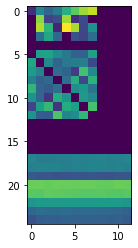

106


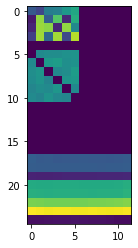

107


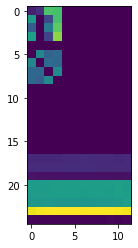

108


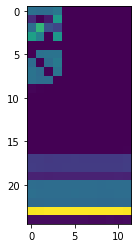

109


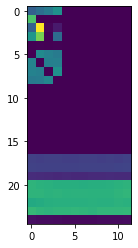

110


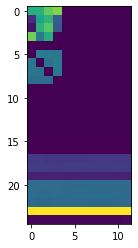

111


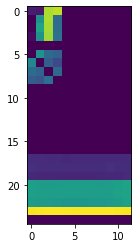

112


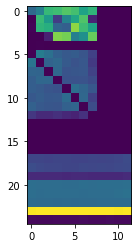

113


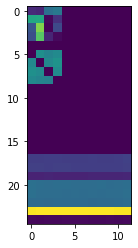

114


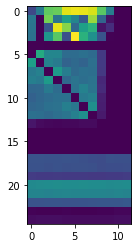

115


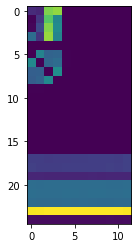

116


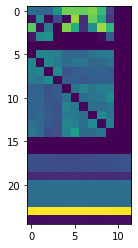

117


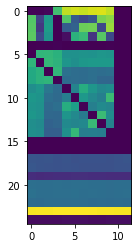

118


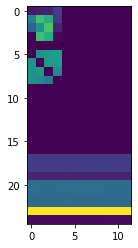

119


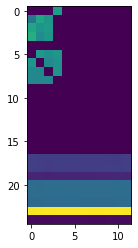

120


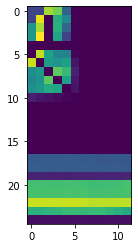

121


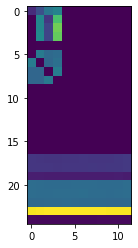

122


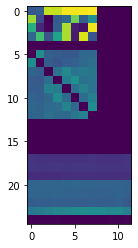

123


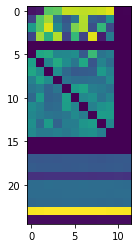

124


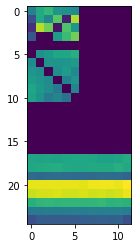

125


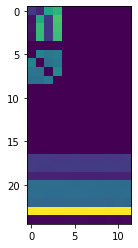

126


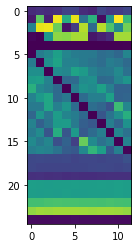

127


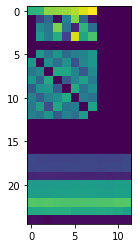

128


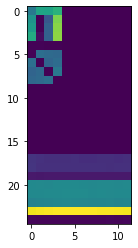

129


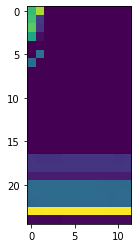

130


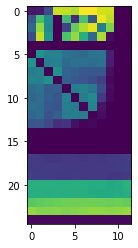

131


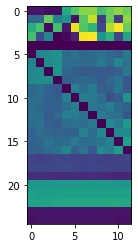

132


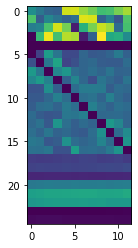

133


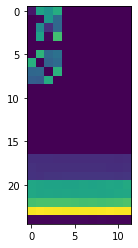

134


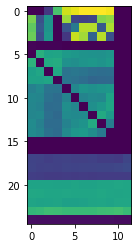

135


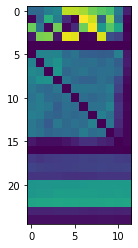

136


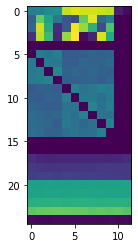

137


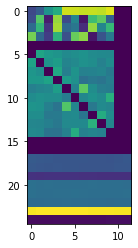

138


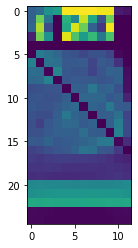

139


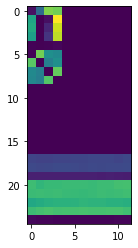

140


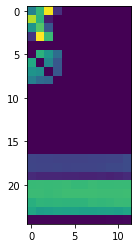

141


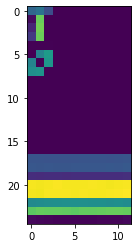

142


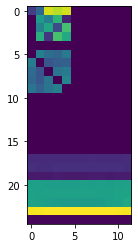

143


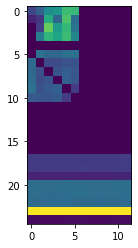

144


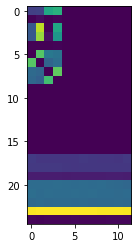

145


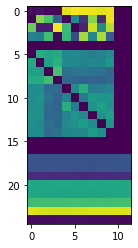

146


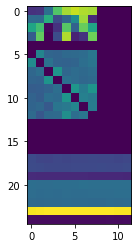

147


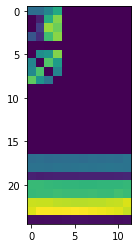

148


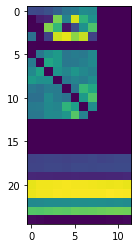

149


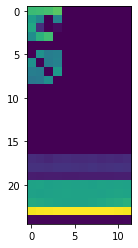

In [54]:
count = 100
for i in gen_images2[100:150]:
    print(count)
    plt.imshow(i)
    count = count+1
    plt.show()